In [1]:
import os
# Set according to your compiler - this setting may be needed for Brian 2
os.environ["CC"] = "gcc"
os.environ["CXX"] = "g++"

import pysnnblaze as pb
import numpy as np
import time
import random
import math
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

In [2]:
# Execution threads
num_threads = 1

# Set to false to disable figure titles (cleaner output for reporting)
figure_titles = False

## Network setup
This network takes inspiration from the work by Maas et al. (2002). It emulates the topology of a cortical microcircuit by arranging neurons in a 3D lattice with a higher probability of connections between nearby neurons. A Gaussian function is used to define connection probabilities.

In [3]:
# Neuron parameters
tau_m = 40e-3       # membrane time constant [s]
C_m = 200e-12       # membrane capacitance [F]
v_rest = -70e-3     # resting potential [V]
v_reset = -70e-3    # reset potential after spike [V]
v_thresh = -50e-3   # threshold [V]
refractory = 2e-3   # refractory period [s]

neuron = pb.LIFNeuron(tau_m=tau_m, C_m=C_m, v_rest=v_rest, v_reset=v_reset, v_thresh=v_thresh, refractory=refractory)

In [4]:
# Network parameters
weight_range_exc = (2.0e-3*C_m, 6.0e-3*C_m)
weight_range_inh = (-12.0e-3*C_m, -4.0e-3*C_m)
network_shape = (10, 10, 10)  # 3D lattice dimensions (x, y, z)
num_neurons = network_shape[0] * network_shape[1] * network_shape[2]
num_inhibitory = int(0.2 * num_neurons)
delay_scale_factor = 5.0e-3  # scale factor for delays

# Define different sigma values for EE, EI, IE, II connections
lambda_EE = 2.0
lambda_EI = 2.0
lambda_IE = 2.0
lambda_II = 2.0

C_EE = 0.3
C_EI = 0.2
C_IE = 0.4
C_II = 0.0

# Define neuron positions in a 3D lattice
positions = {}
i = 0 # neuron indices from 0 to num_neurons-1
for x in range(network_shape[0]):
    for y in range(network_shape[1]):
        for z in range(network_shape[2]):
            positions[i] = (x, y, z)
            i += 1

# Distance-based connection probability (Maas et al.-like)
def connection_probability(d, lambda_val, C):
    return C*math.exp(-(d ** 2)/(lambda_val ** 2))

# Set random seed for reproducibility
random.seed(42)

all_neurons = list(range(num_neurons))
inh_neurons = set(random.sample(all_neurons, num_inhibitory))
exc_neurons = set(all_neurons) - inh_neurons

# Build graph
graph = []
for pre in range(num_neurons):
    for post in range(num_neurons):
        if pre != post:
            x1, y1, z1 = positions[pre]
            x2, y2, z2 = positions[post]
            dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)

            # Select sigma based on pre/post neuron types
            if pre in exc_neurons and post in exc_neurons:
                lambda_conn = lambda_EE
                C_conn = C_EE
            elif pre in exc_neurons and post in inh_neurons:
                lambda_conn = lambda_EI
                C_conn = C_EI
            elif pre in inh_neurons and post in exc_neurons:
                lambda_conn = lambda_IE
                C_conn = C_IE
            else:  # pre in inh_neurons and post in inh_neurons
                lambda_conn = lambda_II
                C_conn = C_II

            # Distance-dependent connection probability
            prob = connection_probability(dist, lambda_conn, C_conn)
            if random.random() < prob:
                # Assign weight based on pre-synaptic neuron type
                weight = random.uniform(*weight_range_inh) if pre in inh_neurons else random.uniform(*weight_range_exc)
                delay = dist*delay_scale_factor  # delay proportional to distance
                graph.append((pre, post, weight, delay))

In [5]:

def plot_3d_network(positions, graph, inh_neurons, neuron_size=20, connection_alpha=0.3):
    """
    Plots a 3D neural network graph.

    Args:
        positions (dict): neuron positions {index: (x, y, z)}
        graph (list): list of connections [(pre, post, weight, delay), ...]
        num_inhibitory (int, optional): number of inhibitory neurons at the end of the list
        neuron_size (int): size of neuron scatter points
        connection_alpha (float): transparency of connection lines
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    total_neurons = len(positions)
        
    # Plot neurons
    inh_label_added = False
    exc_label_added = False

    for idx, (x, y, z) in positions.items():
        if idx in inh_neurons:
            label = 'Inhibitory' if not inh_label_added else ""
            ax.scatter(x, y, z, c='blue', s=neuron_size, label=label, marker='^')
            inh_label_added = True
        else:
            label = 'Excitatory' if not exc_label_added else ""
            ax.scatter(x, y, z, c='red', s=neuron_size, label=label)
            exc_label_added = True


    # Plot connections
    for pre, post, weight, delay in graph:
        x_vals = [positions[pre][0], positions[post][0]]
        y_vals = [positions[pre][1], positions[post][1]]
        z_vals = [positions[pre][2], positions[post][2]]

        color = 'red' if weight > 0 else 'blue'
        ax.plot(x_vals, y_vals, z_vals, c=color, alpha=connection_alpha, linewidth=1)

    # Labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Neural Network Graph')

    # Set integer ticks for all axes
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.zaxis.set_major_locator(MaxNLocator(integer=True))

    ax.legend()
    plt.show()

In [6]:
#plot_3d_network(positions, graph, inh_neurons)

## Spiking Heidelberg Digits

### Loading the dataset

In [7]:
shd_train_filepath = '../data/shd_train.h5'
shd_train_filepath = '../data/shd_test.h5'

with h5py.File('../data/shd_train.h5', 'r') as f:
    print("Top-level groups/datasets:", list(f.keys()))
    print(f['labels']) # Classes
    print(f['spikes/times']) # Spike times
    print(f['spikes/units']) # Neuron indices

    train_labels = f['labels'][:]
    train_spike_times = f['spikes/times'][:]
    train_neuron_indices = f['spikes/units'][:]

with h5py.File('../data/shd_test.h5', 'r') as f:
    test_labels = f['labels'][:]
    test_spike_times = f['spikes/times'][:]
    test_neuron_indices = f['spikes/units'][:]

Top-level groups/datasets: ['extra', 'labels', 'spikes']
<HDF5 dataset "labels": shape (8156,), type "<u2">
<HDF5 dataset "times": shape (8156,), type "|O">
<HDF5 dataset "units": shape (8156,), type "|O">


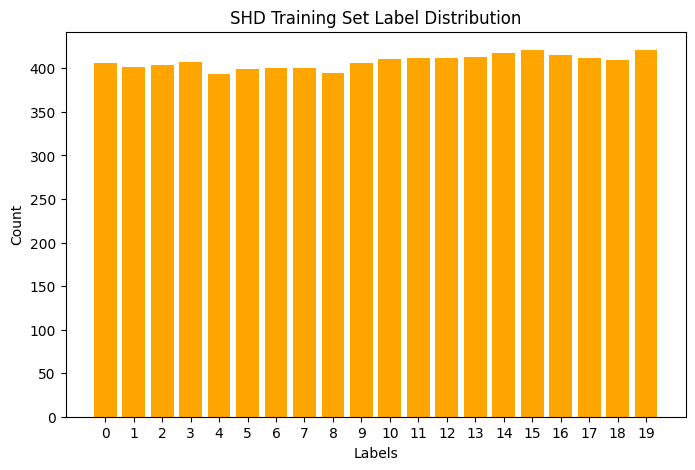

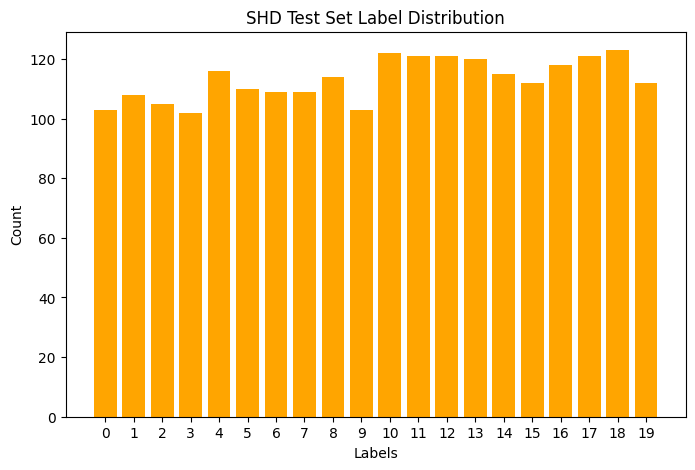

In [8]:
def plot_label_distribution(labels, title="Label Distribution", xlabel="Labels", ylabel="Count", color='orange'):
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    counts = np.array([np.sum(labels == ul) for ul in unique_labels])

    plt.figure(figsize=(8, 5))
    plt.bar(unique_labels, counts, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(unique_labels)
    plt.show()

plot_label_distribution(train_labels, title='SHD Training Set Label Distribution')
plot_label_distribution(test_labels, title='SHD Test Set Label Distribution')

In [9]:
train_spike_events = []
test_spike_events = []

for i in range(train_spike_times.shape[0]):
    events = np.stack((train_spike_times[i], train_neuron_indices[i]), axis=-1)
    train_spike_events.append(events)

for i in range(test_spike_times.shape[0]):
    events = np.stack((test_spike_times[i], test_neuron_indices[i]), axis=-1)
    test_spike_events.append(events)

In [10]:
def plot_raster(spikes, title="Raster Plot", last_reservoir_index=None):
    # Unpack spikes into separate lists
    time = spikes[:,0]
    neurons = spikes[:,1]

    plt.figure(figsize=(10, 6))
    plt.scatter(time, neurons, s=1, c='black')

    # Add horizontal line and labels if last_reservoir_index is given
    if last_reservoir_index is not None:
        plt.axhline(last_reservoir_index + 0.5, color='red', linestyle='--', linewidth=1)
        plt.text(time.max()+0.02, last_reservoir_index-num_neurons*0.03, "Reservoir neurons", color='black', fontsize=10, va='center')
        plt.text(time.max()+0.02, last_reservoir_index+num_neurons*0.03, "Input neurons", color='black', fontsize=10, va='center')
        plt.xlim([0, time.max() + 0.2])

    plt.xlabel("Time")
    plt.ylabel("Neuron")
    plt.title(title)
    plt.show()

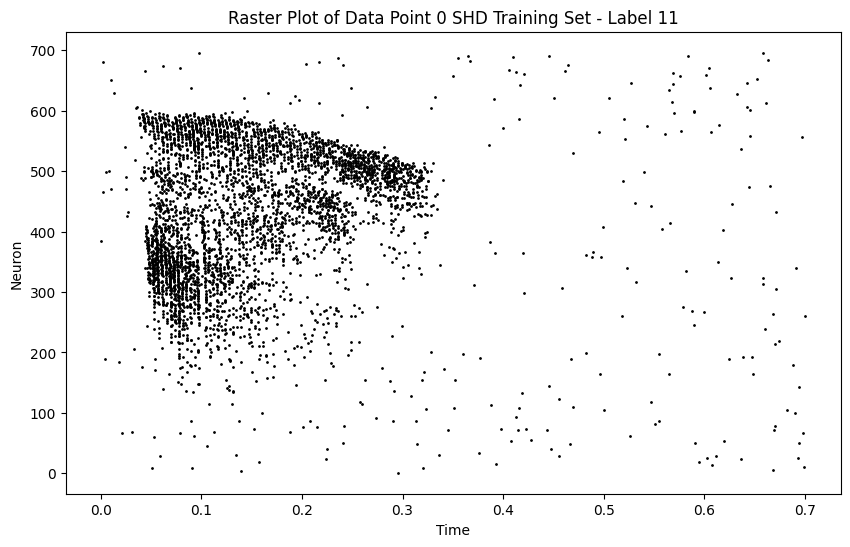

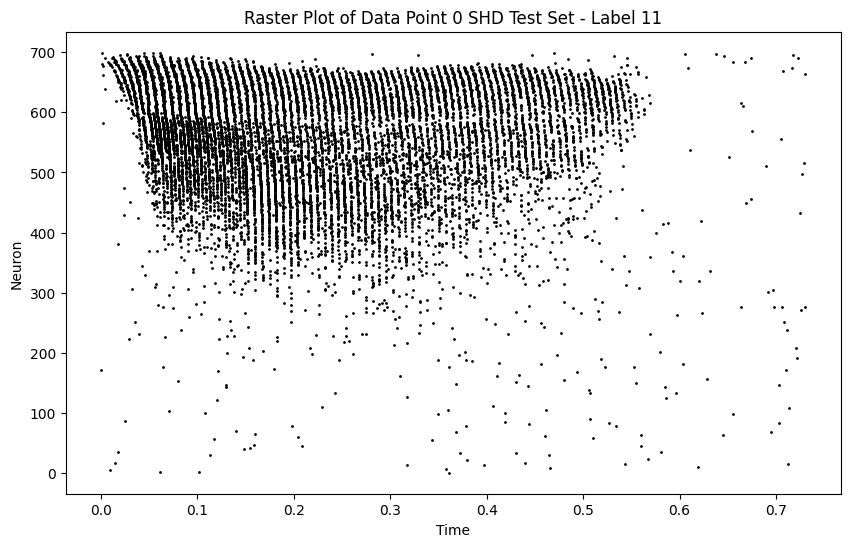

In [11]:
sample = 0
plot_raster(train_spike_events[sample], title=f'Raster Plot of Data Point {sample} SHD Training Set - Label {train_labels[sample]}')
plot_raster(test_spike_events[sample], title=f'Raster Plot of Data Point {sample} SHD Test Set - Label {train_labels[sample]}')

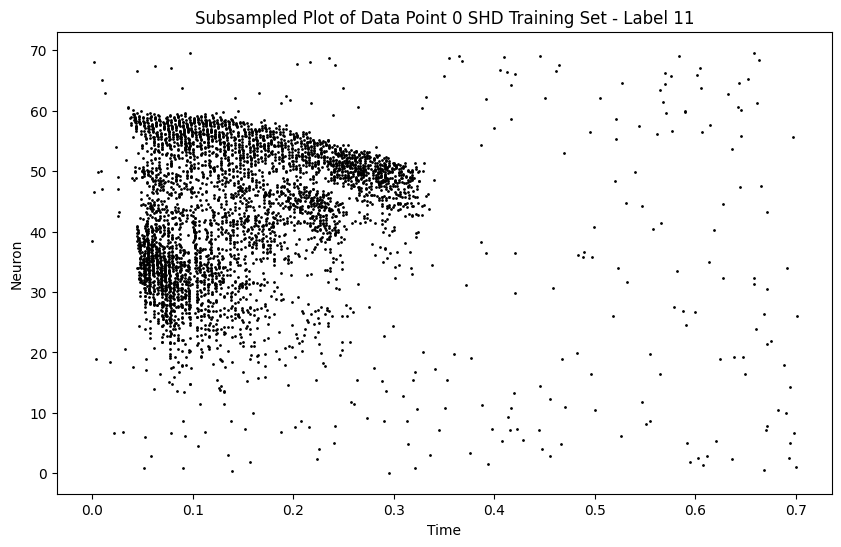

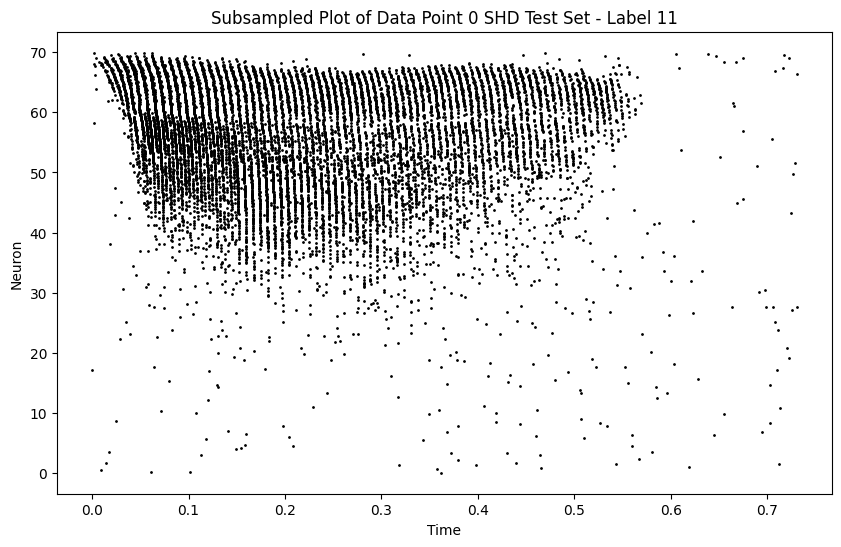

In [12]:
subsampling = 10

def subsample_spikes(spike_events_set, subsampling):
    subs_spike_events_set = []
    for spike_events in spike_events_set:
        subsampled_events = spike_events[spike_events[:,1] % subsampling == 0]
        subsampled_events[:, 1] = subsampled_events[:, 1]/subsampling
        subs_spike_events_set.append(subsampled_events)
    return subs_spike_events_set

def subsample_spikes(spike_events_set, subsampling):
    subs_spike_events_set = []
    for spike_events in spike_events_set:
        subsampled_events = spike_events
        subsampled_events[:, 1] = subsampled_events[:, 1]/subsampling
        subs_spike_events_set.append(subsampled_events)
    return subs_spike_events_set

train_spike_events = subsample_spikes(train_spike_events, subsampling)
test_spike_events = subsample_spikes(test_spike_events, subsampling)

plot_raster(train_spike_events[sample], title=f'Subsampled Plot of Data Point {sample} SHD Training Set - Label {train_labels[sample]}')
plot_raster(test_spike_events[sample], title=f'Subsampled Plot of Data Point {sample} SHD Test Set - Label {train_labels[sample]}')

### Simulating network and retrieving results

In [13]:
# Initialize network and monitorstrain_spike_events
start_time = time.perf_counter()
nn = pb.NeuralNetwork()
nn.set_num_exec_threads(num_threads)
spike_monitor = pb.SpikeMonitor()
nn.set_spike_monitor(spike_monitor)
nn.add_neuron_population(num_neurons, neuron) # reservoir neurons

# Instantiate the graph into the neural network
for pre, post, weight, delay in graph:
    syn = pb.Synapse(pre, post, weight, delay)
    nn.add_synapse(syn)

end_time = time.perf_counter()
print(f"Setup finished in {end_time - start_time:.6f} seconds")

Setup finished in 0.010172 seconds


In [14]:
def build_input_layer(num_in, num_res, in_slice_start, res_slice_start, p_res_input, num_inp_to_res, weight_range, delay_range):
    '''
    Builds a graph connecting input neurons to reservoir neurons.
    The first reservoir neuron index must be specified (reservoir and input neurons must occupy a continuous slice of neurons).
    '''
    inp_graph = []
    num_targets = int(p_res_input * num_res)

    valid_res_neurons = np.random.choice(num_res, size=num_targets, replace=False)

    for i in range(num_in):
        selected_res_neurons = np.random.choice(valid_res_neurons, size=num_inp_to_res, replace=False)
        for j in selected_res_neurons:
            weight = np.random.uniform(weight_range[0], weight_range[1]) # C
            delay = np.random.uniform(delay_range[0], delay_range[1])  # ms
            inp_graph.append((in_slice_start+i, res_slice_start + j, weight, delay))

    return inp_graph

num_shd_inputs = 700 // subsampling  # original SHD input size is 700

inp_graph = build_input_layer(
    num_in=num_shd_inputs,
    num_res=num_neurons,
    in_slice_start=num_neurons,
    res_slice_start=0,
    p_res_input=1,
    num_inp_to_res=5,
    weight_range=(30e-3*C_m, 30e-3*C_m),
    delay_range=(0.1e-3, 0.1e-3)
)

inp_neuron = pb.InputNeuron()
nn.add_neuron_population(num_shd_inputs, inp_neuron) # reservoir neurons

# Build input layer connections
for pre, post, weight, delay in inp_graph:
    syn = pb.Synapse(pre, post, weight, delay)
    nn.add_synapse(syn)

In [15]:
def input_to_reservoir(nn, spike_events, in_slice_start):
    '''
    nn: snnblaze NeuralNetwork instance
    spike_events: array of shape (num_spikes, 2) with columns [spike_time, neuron_index]
    '''
    for spike_time, neuron_index in spike_events:
        nn.schedule_spike_event(spike_time, int(in_slice_start+neuron_index), weight)

def convolve_spikes_exponential(spike_list, num_neurons, dt=0.001, tau=0.02, t_start=0, t_interval=None):
    if not spike_list:
        raise ValueError("Spike list is empty.")
    
    # Filtering according to start time
    spike_list = [spike for spike in spike_list if spike[0] >= t_start]

    if t_interval is None:
        t_interval = spike_list[-1][0] - t_start # The simulator outputs sorted spike times
    
    # Determine dimensions
    times = np.arange(0, t_interval, dt)
    rates = np.zeros((num_neurons, len(times)))
    
    # Exponential kernel (causal)
    kernel_length = int(5 * tau / dt)  # 5*tau cutoff
    kernel_t = np.arange(0, kernel_length * dt, dt)
    kernel = np.exp(-kernel_t / tau)
    
    # Fill spike trains and convolve
    for t, n in spike_list:
        idx = int((t-t_start) / dt)
        if idx < len(times):
            rates[n, idx] += 1.0 / dt  # convert spike to impulse
    
    for n in range(num_neurons):
        rates[n] = np.convolve(rates[n], kernel, mode='full')[:len(times)]
    
    return rates

Run finished in 0.036208 seconds


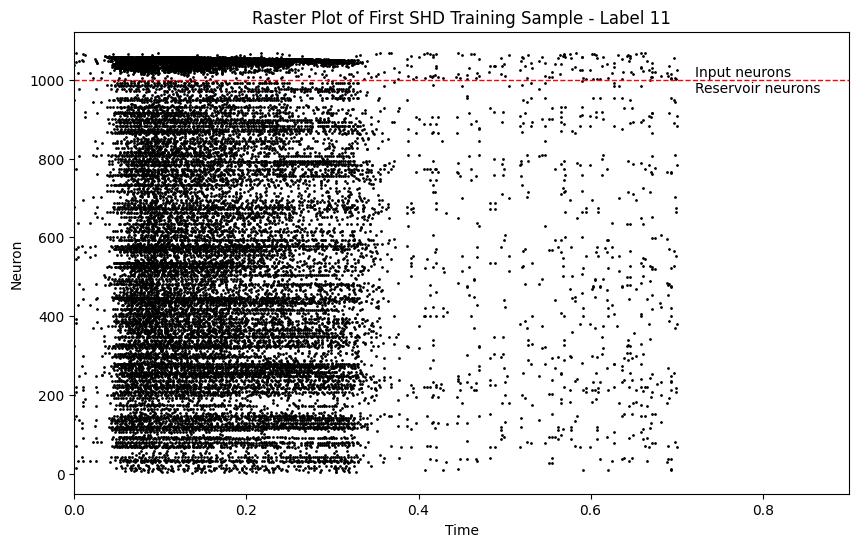

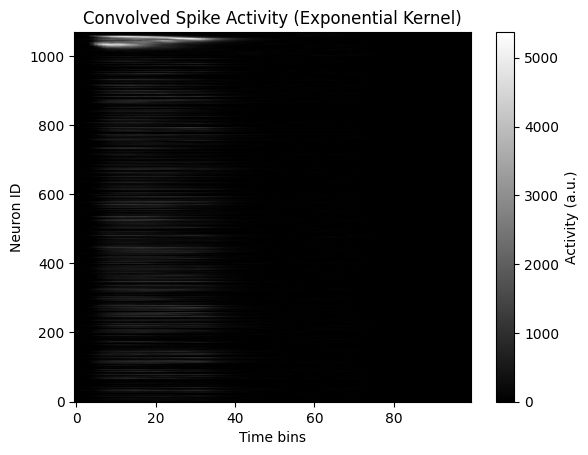

In [16]:
# Add input spikes for the first training sample
input_to_reservoir(nn, train_spike_events[0], in_slice_start=num_neurons)

start_time = time.perf_counter()
nn.run(1.0)
end_time = time.perf_counter()
print(f"Run finished in {end_time - start_time:.6f} seconds")

plot_raster(np.array(spike_monitor.spike_list), title=f'Raster Plot of First SHD Training Sample - Label {train_labels[0]}', last_reservoir_index=num_neurons-1)

cont_arr = convolve_spikes_exponential(spike_monitor.spike_list, num_neurons=nn.size(), dt=0.01, tau=0.05, t_start=0, t_interval=1)

plt.imshow(cont_arr, cmap='gray', aspect='auto', origin='lower')
plt.colorbar(label='Activity (a.u.)')
plt.xlabel('Time bins')
plt.ylabel('Neuron ID')
plt.title('Convolved Spike Activity (Exponential Kernel)')
plt.show()

### Running on the full SHD dataset

In [17]:
# Test performance of each step
t0 = time.perf_counter()
nn.reset_monitors()
t1 = time.perf_counter()

input_to_reservoir(nn, train_spike_events[0], in_slice_start=num_neurons)
t2 = time.perf_counter()

curr_sim_time = nn.sim_time
nn.run(1.0)
t3 = time.perf_counter()

cont_arr = convolve_spikes_exponential(
    spike_monitor.spike_list,
    nn.size(),
    dt=0.01,
    tau=0.05,
    t_start=curr_sim_time,
    t_interval=1.0
)
t4 = time.perf_counter()

# --- Compute durations ---
reset_t = t1 - t0
input_t = t2 - t1
run_t = t3 - t2
conv_t = t4 - t3
total_t = t4 - t0

print(f"reset_monitors(): {reset_t:.6f} s")
print(f"input_to_reservoir(): {input_t:.6f} s")
print(f"nn.run(): {run_t:.6f} s")
print(f"convolve_spikes_exponential(): {conv_t:.6f} s")
print(f"Total: {total_t:.6f} s")

reset_monitors(): 0.000071 s
input_to_reservoir(): 0.015381 s
nn.run(): 0.031126 s
convolve_spikes_exponential(): 0.018538 s
Total: 0.065116 s


In [18]:
def run_spikes_through_network(spike_events, nn, in_slice_start, sim_interval=1.0, conv_dt=0.01, conv_tau=0.05):
    nn.reset_monitors()
    input_to_reservoir(nn, spike_events, in_slice_start)

    curr_sim_time = nn.sim_time
    nn.run(sim_interval)

    # Compute spike counts per neuron
    spike_counts = np.zeros(nn.size(), dtype=int)
    for _, idx in spike_monitor.spike_list:
        spike_counts[idx] += 1

    # Convolve spikes to get continuous state
    cont_arr = convolve_spikes_exponential(spike_monitor.spike_list, nn.size(), dt=conv_dt, tau=conv_tau, t_start=curr_sim_time, t_interval=sim_interval)

    return cont_arr.T, spike_counts # Return with shape (time, neuron)

In [19]:
sim_margin = 0.5
conv_tau = 0.3
conv_dt = 0.05

shd_save_dir = "shd_arrays"
shd_train_dir = os.path.join(shd_save_dir, 'train')
shd_test_dir = os.path.join(shd_save_dir, 'test')
os.makedirs(shd_train_dir, exist_ok=True)
os.makedirs(shd_test_dir, exist_ok=True)

In [20]:
# Running the training set
for i in tqdm(range(len(train_spike_events))):
    sim_end_time = train_spike_events[i][-1][0] + sim_margin
    cont_arr, spike_counts = run_spikes_through_network(
        train_spike_events[i],
        nn,
        num_neurons,
        sim_interval=sim_end_time,
        conv_dt=conv_dt,
        conv_tau=conv_tau
    )

    # Save only data on reservoir neurons
    cont_arr = cont_arr[:, :num_neurons]
    spike_counts = spike_counts[:num_neurons]

    # Save to local folder
    np.save(os.path.join(shd_train_dir, f"train_arr_{i}.npy"), cont_arr)
    np.save(os.path.join(shd_train_dir, f"train_counts_{i}.npy"), spike_counts)

100%|██████████| 8156/8156 [13:45<00:00,  9.88it/s]


In [21]:
# Running the test set
for i in tqdm(range(len(test_spike_events))):
    sim_end_time = test_spike_events[i][-1][0] + sim_margin
    cont_arr, spike_counts = run_spikes_through_network(
        test_spike_events[i],
        nn,
        num_neurons,
        sim_interval=sim_end_time,
        conv_dt=conv_dt,
        conv_tau=conv_tau
    )

    # Save only data on reservoir neurons
    cont_arr = cont_arr[:, :num_neurons]
    spike_counts = spike_counts[:num_neurons]

    # Save to local folder
    np.save(os.path.join(shd_test_dir, f"test_arr_{i}.npy"), cont_arr)
    np.save(os.path.join(shd_test_dir, f"test_counts_{i}.npy"), spike_counts)

  0%|          | 0/2264 [00:00<?, ?it/s]

100%|██████████| 2264/2264 [03:46<00:00, 10.00it/s]


### Training a classifier with spike counts

In [22]:
def load_and_stack_counts(directory, prefix):
    """Load all .npy arrays from a directory and stack them vertically. Also extend labels to match timesteps."""
    files = sorted(
        [f for f in os.listdir(directory) if f.startswith(prefix) and f.endswith(".npy")],
        key=lambda x: int(x.split("_")[2].split(".")[0])
    )

    arrays = [np.load(os.path.join(directory, f)) for f in tqdm(files, desc=f"Loading {prefix} arrays")]
    stacked = np.vstack(arrays)
    return stacked

# Load and stack both train and test data
X_train = load_and_stack_counts(shd_train_dir, "train_counts")
X_test = load_and_stack_counts(shd_test_dir, "test_counts")
y_train = train_labels
y_test = test_labels

Loading test_counts arrays: 100%|██████████| 2264/2264 [00:00<00:00, 13629.95it/s]


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on X_train and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the regressor on the scaled data
regressor = LogisticRegression(multi_class='multinomial', max_iter=1000, n_jobs=num_threads, verbose=True, C=0.01)
regressor.fit(X_train_scaled, y_train)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        20020     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99573D+00    |proj g|=  1.08589D-01

At iterate   50    f=  5.25762D-01    |proj g|=  2.61537D-03

At iterate  100    f=  5.11092D-01    |proj g|=  1.21612D-03

At iterate  150    f=  5.06051D-01    |proj g|=  9.52073D-04

At iterate  200    f=  5.04569D-01    |proj g|=  6.79979D-04

At iterate  250    f=  5.03869D-01    |proj g|=  3.22687D-04

At iterate  300    f=  5.03583D-01    |proj g|=  2.16317D-04

At iterate  350    f=  5.03405D-01    |proj g|=  1.22862D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial', n_jobs=1,
                   verbose=True)

Training accuracy: 95.02%
Test accuracy: 77.52%


<Figure size 600x600 with 0 Axes>

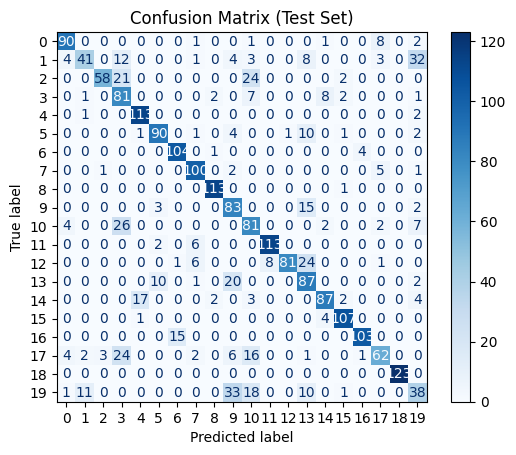

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train_pred_labels = regressor.predict(X_train_scaled)
test_pred_labels = regressor.predict(X_test_scaled)

# Compute accuracy
acc_train = np.sum(train_pred_labels == train_labels) / len(train_labels)
acc_test = np.sum(test_pred_labels == test_labels) / len(test_labels)

print(f"Training accuracy: {acc_train*100:.2f}%")
print(f"Test accuracy: {acc_test*100:.2f}%")

# ---- Confusion matrix (for test set) ----
cm = confusion_matrix(test_labels, test_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', colorbar=True)
plt.title("Confusion Matrix (Test Set)")
plt.show()

### Training a readout layer

In [25]:
shd_save_dir = "shd_arrays"
shd_train_dir = os.path.join(shd_save_dir, 'train')
shd_test_dir = os.path.join(shd_save_dir, 'test')

def load_and_stack_arrays(directory, prefix, labels):
    """Load all .npy arrays from a directory and stack them vertically. Also extend labels to match timesteps."""
    files = sorted(
        [f for f in os.listdir(directory) if f.startswith(prefix) and f.endswith(".npy")],
        key=lambda x: int(x.split("_")[2].split(".")[0])
    )

    arrays = [np.load(os.path.join(directory, f)) for f in tqdm(files, desc=f"Loading {prefix} arrays")]
    stacked = np.vstack(arrays)
    ext_labels = [np.ones(arrays[i].shape[0])*labels[i] for i in range(len(arrays))] # extend labels to each timestep
    ext_labels = np.concatenate(ext_labels)
    sample_ids = np.concatenate([np.ones(arrays[i].shape[0])*i for i in range(len(files))])
    print(f"{prefix} data shape:", stacked.shape)
    return stacked, ext_labels, sample_ids

# Load and stack both train and test data
X_train, y_train, train_sample_ids = load_and_stack_arrays(shd_train_dir, "train_arr", train_labels)
X_test, y_test, test_sample_ids = load_and_stack_arrays(shd_test_dir, "test_arr", test_labels)

Loading train_arr arrays: 100%|██████████| 8156/8156 [00:01<00:00, 5031.54it/s]


train_arr data shape: (202396, 1000)


Loading test_arr arrays: 100%|██████████| 2264/2264 [00:00<00:00, 7613.01it/s]


test_arr data shape: (55991, 1000)


In [26]:
def one_hot_encode(labels):
    labels = np.asarray(labels)  # ensure it's a NumPy array
    if labels.ndim != 1:
        raise ValueError("Input labels must be a 1D array")
    num_classes = np.max(labels) + 1
    one_hot = np.eye(num_classes)[labels]
    return one_hot

y_train_oh = one_hot_encode(y_train.astype(int))
y_test_oh = one_hot_encode(y_test.astype(int))

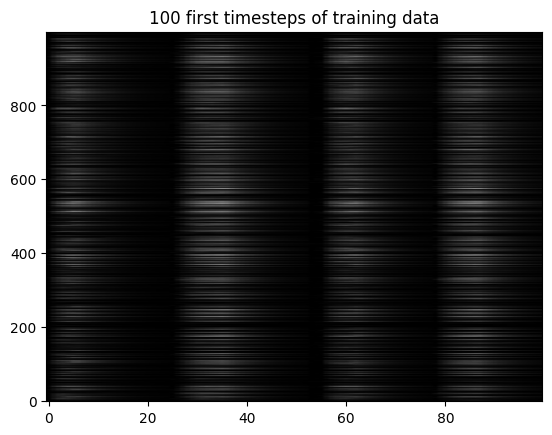

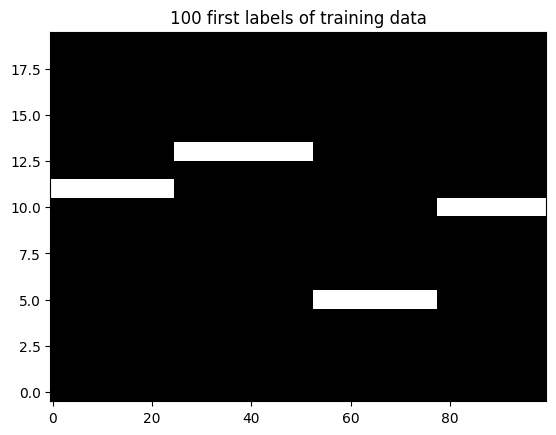

In [27]:
# Temporary fix, the matrices should be stored with shape (num_samples, num_features)
plt.title('100 first timesteps of training data')
plt.imshow(X_train[:100].T, cmap='gray', aspect='auto', origin='lower')
plt.show()

plt.title('100 first labels of training data')
plt.imshow(y_train_oh[:100].T, cmap='gray', aspect='auto', origin='lower')
plt.show()

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on X_train and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the regressor on the scaled data
regressor = LogisticRegression(multi_class='multinomial', max_iter=1000, n_jobs=num_threads, verbose=True, C=0.01)
regressor.fit(X_train_scaled, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        20020     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99573D+00    |proj g|=  8.13357D-02


 This problem is unconstrained.



At iterate   50    f=  1.29137D+00    |proj g|=  8.92795D-03

At iterate  100    f=  1.12047D+00    |proj g|=  4.53104D-03

At iterate  150    f=  1.06647D+00    |proj g|=  3.87506D-03

At iterate  200    f=  1.04752D+00    |proj g|=  1.87325D-03

At iterate  250    f=  1.04007D+00    |proj g|=  8.95804D-04

At iterate  300    f=  1.03703D+00    |proj g|=  7.15491D-04

At iterate  350    f=  1.03572D+00    |proj g|=  6.77728D-04

At iterate  400    f=  1.03514D+00    |proj g|=  3.64087D-04

At iterate  450    f=  1.03483D+00    |proj g|=  3.42438D-04

At iterate  500    f=  1.03464D+00    |proj g|=  2.87671D-04

At iterate  550    f=  1.03451D+00    |proj g|=  1.97304D-04

At iterate  600    f=  1.03443D+00    |proj g|=  1.85399D-04

At iterate  650    f=  1.03437D+00    |proj g|=  1.31300D-04

At iterate  700    f=  1.03433D+00    |proj g|=  1.07878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial', n_jobs=1,
                   verbose=True)

In [29]:
y_pred_train = regressor.predict_proba(X_train_scaled)
y_pred_test = regressor.predict_proba(X_test_scaled)

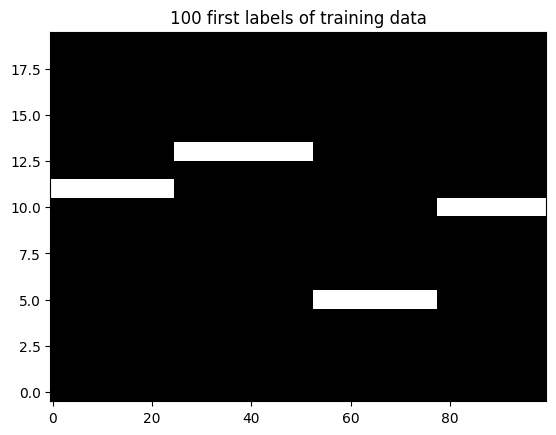

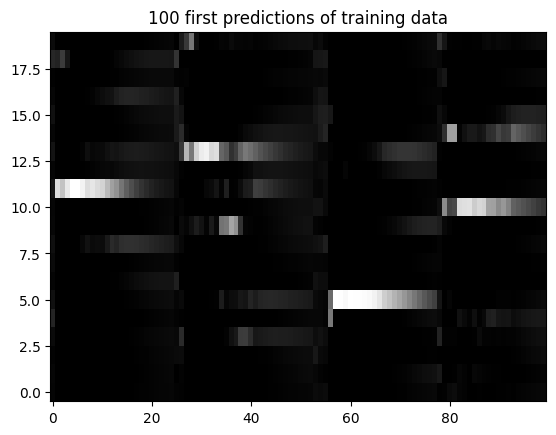

In [30]:
plt.title('100 first labels of training data')
plt.imshow(y_train_oh[:100].T, cmap='gray', aspect='auto', origin='lower')
plt.show()

plt.title('100 first predictions of training data')
plt.imshow(y_pred_train[:100].T, cmap='gray', aspect='auto', origin='lower')
plt.show()

In [31]:
def wta_prediction(y_pred, train_sample_ids):
    pred_labels = []
    for i in range(int(train_sample_ids[-1])+1):
        sample_mask = (train_sample_ids == i)
        y_pred_sample = y_pred[sample_mask]

        # Majority vote
        sample_argmax = np.argmax(y_pred_sample)
        _, pred_label = np.unravel_index(sample_argmax, y_pred_sample.shape)
        pred_labels.append(pred_label)
    return np.array(pred_labels)

# Build classifier with WTA policy
train_pred_labels = wta_prediction(y_pred_train, train_sample_ids)
test_pred_labels = wta_prediction(y_pred_test, test_sample_ids)

Training accuracy: 93.23%
Test accuracy: 70.76%


<Figure size 600x600 with 0 Axes>

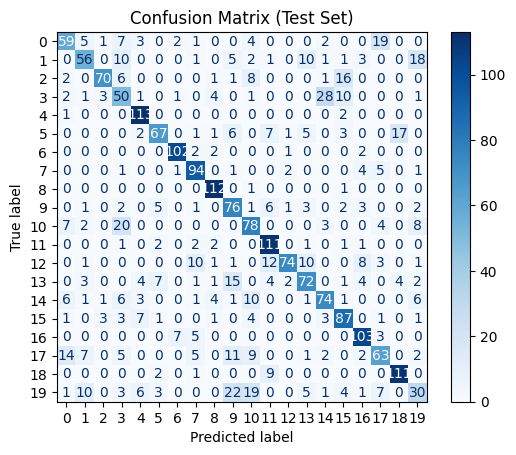

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute accuracy
acc_train = np.sum(train_pred_labels == train_labels) / len(train_labels)
acc_test = np.sum(test_pred_labels == test_labels) / len(test_labels)

print(f"Training accuracy: {acc_train*100:.2f}%")
print(f"Test accuracy: {acc_test*100:.2f}%")

# ---- Confusion matrix (for test set) ----
cm = confusion_matrix(test_labels, test_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', colorbar=True)
plt.title("Confusion Matrix (Test Set)")
plt.show()